In [1]:
# - Imports & setup
import sys, os
sys.path.append(os.path.abspath(".."))

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from src import load_bcn20000, get_transforms

In [2]:
# - Device helper -
def get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

In [3]:
# — Binary mapping + Data pipeline —
class TorchImageDataset(Dataset):
    def __init__(self, hf_ds, transform, has_labels=True):
        self.ds = hf_ds
        self.tf = transform
        self.has_labels = has_labels
        self.label_feature = hf_ds.features["label"] if has_labels else None
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.open(img).convert("RGB")
        x = self.tf(img)
        if self.has_labels:
            y = ex["label"]
            if isinstance(y, str):
                y = self.label_feature.str2int(y)
            else:
                y = int(y)
            return x, y
        return x

def get_dataloaders(batch_size=64):
    malignant = {"MEL","SCC","BCC"}
    all_labels = ["MEL","SCC","NV","BCC","BKL","AK","DF","VASC"]
    label_mapping = {lbl:("malignant" if lbl in malignant else "benign") for lbl in all_labels}
    train_hf = load_bcn20000(split="train", filename_column="bcn_filename", label_column="diagnosis", label_mapping=label_mapping)
    val_hf   = load_bcn20000(split="validation", filename_column="bcn_filename", label_column="diagnosis", label_mapping=label_mapping)
    label_names = train_hf.features["label"].names
    train_tf = get_transforms(train=True)
    eval_tf  = get_transforms(train=False)
    train_ds = TorchImageDataset(train_hf, train_tf, has_labels=True)
    val_ds   = TorchImageDataset(val_hf,   eval_tf,  has_labels=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
    return train_loader, val_loader, label_names

In [4]:
# — Custom CNN (configurable conv filters) —
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k, s=1, p=None):
        super().__init__()
        pad = (k//2) if p is None else p
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=pad),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    def forward(self, x):
        return self.block(x)

class FlexibleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, channels, kernels, fc_dim=128):
        super().__init__()
        blocks = []
        c_in = in_channels
        for c_out, k in zip(channels, kernels):
            blocks.append(ConvBlock(c_in, c_out, k))
            c_in = c_out
        self.features = nn.Sequential(*blocks)
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            feat = self.features(dummy)
            flat_dim = feat.view(1, -1).size(1)
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, fc_dim),
            nn.ReLU(inplace=True),
            nn.Linear(fc_dim, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def build_custom_cnn(num_classes, channels, kernels):
    return FlexibleCNN(in_channels=3, num_classes=num_classes, channels=channels, kernels=kernels, fc_dim=128)

In [5]:
# — TorchVision models (and pretrained) —
from torchvision import models

def _replace_classifier_resnet(model, num_classes):
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

def _replace_classifier_mobilenet(model, num_classes):
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model

def _replace_classifier_efficientnet(model, num_classes):
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)
    return model

def build_resnet18(num_classes, use_pretrained=True):
    try:
        if use_pretrained:
            weights = models.ResNet18_Weights.DEFAULT
            model = models.resnet18(weights=weights)
        else:
            model = models.resnet18(weights=None)
    except Exception:
        model = models.resnet18(weights=None)
    return _replace_classifier_resnet(model, num_classes)

def build_mobilenet_v3_small(num_classes, use_pretrained=True):
    try:
        if use_pretrained:
            weights = models.MobileNet_V3_Small_Weights.DEFAULT
            model = models.mobilenet_v3_small(weights=weights)
        else:
            model = models.mobilenet_v3_small(weights=None)
    except Exception:
        model = models.mobilenet_v3_small(weights=None)
    return _replace_classifier_mobilenet(model, num_classes)

def build_efficientnet_b0(num_classes, use_pretrained=True):
    try:
        if use_pretrained:
            weights = models.EfficientNet_B0_Weights.DEFAULT
            model = models.efficientnet_b0(weights=weights)
        else:
            model = models.efficientnet_b0(weights=None)
    except Exception:
        model = models.efficientnet_b0(weights=None)
    return _replace_classifier_efficientnet(model, num_classes)

In [6]:
# - Train & evaluate
def evaluate(model, data_loader, device, criterion):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    return running_loss / max(1, len(data_loader)), correct / max(1, total)

def train_one_model(model, train_loader, val_loader, device, epochs=5, lr=1e-3, class_weights=None):
    model = model.to(device)
    if class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    else:
        criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"loss": [], "val_loss": [], "val_acc": []}
    for epoch in range(1, epochs+1):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=True)
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            running += loss.item()
            pbar.set_postfix(batch_loss=f"{loss.item():.4f}")
        tr_loss = running / max(1, len(train_loader))
        val_loss, val_acc = evaluate(model, val_loader, device, criterion)
        history["loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
    return model, history

In [7]:
# — Utilities: class weights, summaries, plotting —
def compute_class_weights(train_loader, num_classes, device):
    counts = torch.zeros(num_classes, dtype=torch.long)
    for xb, yb in train_loader:
        binc = torch.bincount(yb, minlength=num_classes)
        counts += binc
    w = 1.0 / counts.clamp(min=1).float()
    w = w / w.sum() * num_classes
    return w.to(device)

def summarize_results(results):
    rows = []
    for r in results:
        name = r["name"]
        hist = r["history"]
        rows.append((name, round(hist["val_acc"][-1], 4)))
    rows = sorted(rows, key=lambda x: x[1], reverse=True)
    return rows

def plot_history(tag, history):
    plt.figure(figsize=(7,4))
    plt.plot(history["loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title(f"Loss: {tag}")
    plt.show()
    plt.figure(figsize=(7,4))
    plt.plot(history["val_acc"], label="val_acc")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Val Acc: {tag}")
    plt.show()

In [8]:
# — Run convolution filter experiments —
def run_conv_experiments(epochs=5, batch_size=64, lr=1e-3):
    device = get_device()
    train_loader, val_loader, label_names = get_dataloaders(batch_size=batch_size)
    num_classes = len(label_names)
    class_weights = compute_class_weights(train_loader, num_classes, device)
    configs = [
        {"name":"custom_k3_32-64","channels":[32,64],"kernels":[3,3]},
        {"name":"custom_k5_32-64","channels":[32,64],"kernels":[5,5]},
        {"name":"custom_k3_64-128","channels":[64,128],"kernels":[3,3]},
        {"name":"custom_mixed_3-5_32-64","channels":[32,64],"kernels":[3,5]},
    ]
    results = []
    for cfg in configs:
        model = build_custom_cnn(num_classes=num_classes, channels=cfg["channels"], kernels=cfg["kernels"])
        model, hist = train_one_model(model, train_loader, val_loader, device, epochs=epochs, lr=lr, class_weights=class_weights)
        results.append({"name":cfg["name"], "history":hist})
    return results

In [9]:
# — Run model architecture comparisons —
def run_model_experiments(epochs=5, batch_size=64, lr=1e-3, use_pretrained=True):
    device = get_device()
    train_loader, val_loader, label_names = get_dataloaders(batch_size=batch_size)
    num_classes = len(label_names)
    class_weights = compute_class_weights(train_loader, num_classes, device)
    configs = [
        {"name":"resnet18",         "builder":lambda: build_resnet18(num_classes, use_pretrained)},
        {"name":"mobilenet_v3_s",   "builder":lambda: build_mobilenet_v3_small(num_classes, use_pretrained)},
        {"name":"efficientnet_b0",  "builder":lambda: build_efficientnet_b0(num_classes, use_pretrained)},
    ]
    results = []
    for cfg in configs:
        model = cfg["builder"]()
        model, hist = train_one_model(model, train_loader, val_loader, device, epochs=epochs, lr=lr, class_weights=class_weights)
        results.append({"name":cfg["name"], "history":hist})
    return results

In [10]:
# — Execute: conv filters —
conv_results = run_conv_experiments(epochs=5, batch_size=64, lr=1e-3)
summarize_results(conv_results)

Casting the dataset:   0%|          | 0/12413 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12413 [00:00<?, ? examples/s]

Epoch 1/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/194 [00:00<?, ?it/s]

[('custom_k3_32-64', 0.7),
 ('custom_k3_64-128', 0.6774),
 ('custom_mixed_3-5_32-64', 0.5089),
 ('custom_k5_32-64', 0.4911)]

In [11]:
# — Execute: model comparisons —
model_results = run_model_experiments(epochs=5, batch_size=64, lr=1e-3, use_pretrained=True)
summarize_results(model_results)

Casting the dataset:   0%|          | 0/12413 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/12413 [00:00<?, ? examples/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/kornel/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 14.9MB/s]


Epoch 1/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/194 [00:00<?, ?it/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /Users/kornel/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 12.3MB/s]


Epoch 1/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/194 [00:00<?, ?it/s]

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/kornel/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:01<00:00, 15.5MB/s]


Epoch 1/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/194 [00:00<?, ?it/s]

[('efficientnet_b0', 0.9097), ('mobilenet_v3_s', 0.8887), ('resnet18', 0.7758)]

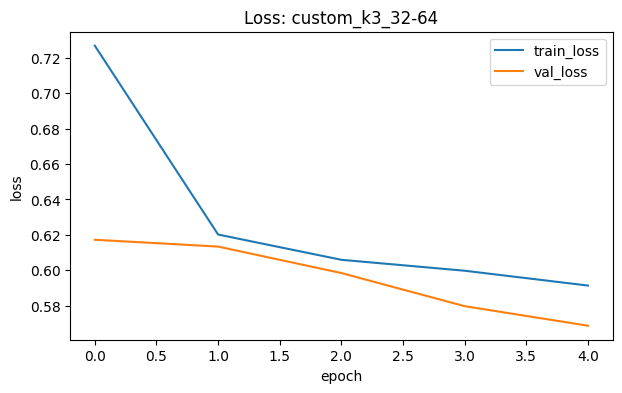

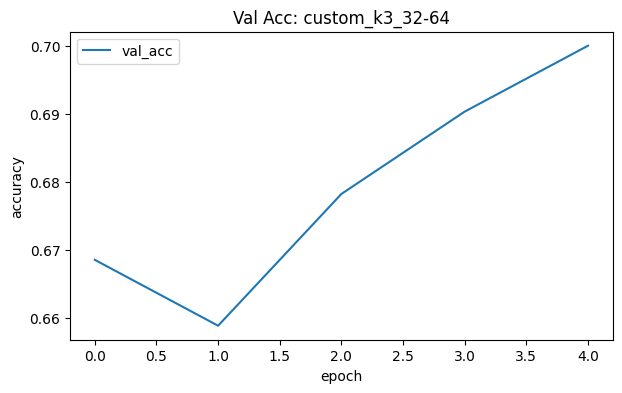

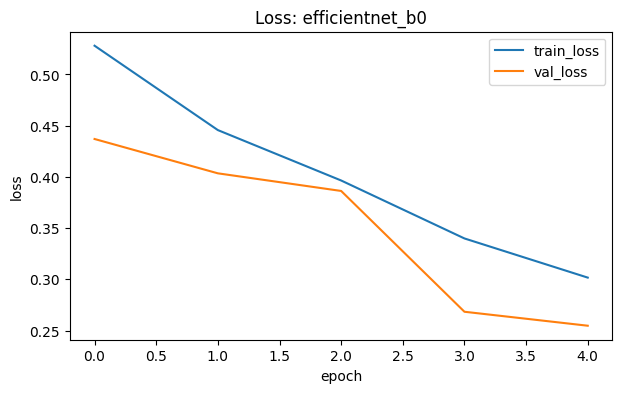

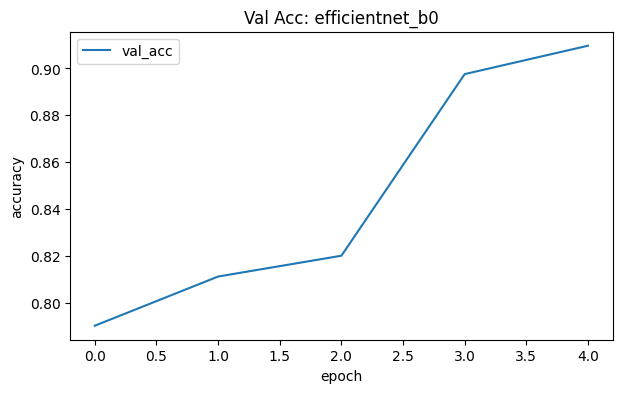

(('custom_k3_32-64', 0.7), ('efficientnet_b0', 0.9097))

In [12]:
# — Plot best runs —
best_conv = max(conv_results, key=lambda r: r["history"]["val_acc"][-1])
plot_history(best_conv["name"], best_conv["history"])

best_model = max(model_results, key=lambda r: r["history"]["val_acc"][-1])
plot_history(best_model["name"], best_model["history"])

(best_conv["name"], round(best_conv["history"]["val_acc"][-1],4)), (best_model["name"], round(best_model["history"]["val_acc"][-1],4))